In [2]:
import pandas as pd

# 데이터 로드
df = pd.read_csv('creditcard.csv')

# 데이터 구조 확인
print(df.head())
print(df['Class'].value_counts()) # 0: 정상, 1: 사기 (비율 확인이 중요!)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

1. 클래스 불균형 확인 (The Class Imbalance)
- FDS 데이터의 가장 큰 특징은 **"사기꾼은 정말 적다"**는 것.

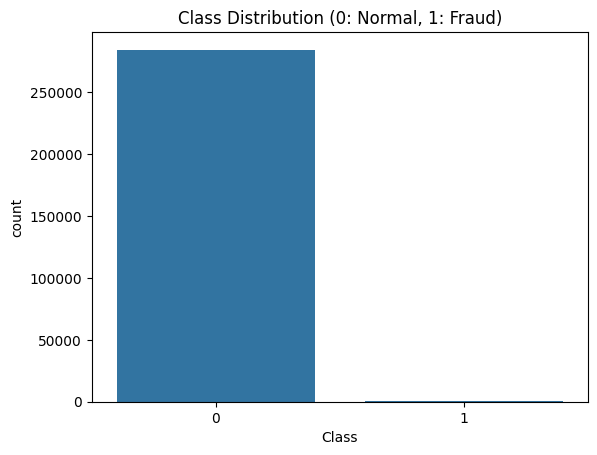

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 시각화
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

# 정확한 비율 계산
print(df['Class'].value_counts(normalize=True))

- 사기 거래(1)가 0.17% 정도.

- 인사이트: 만약 모델이 모든 거래를 정상(0)이라고만 대답해도 정확도가 99.8%가 나옴. '정확도(Accuracy)'가 아무 의미 없다.

2. 특징(Feature) 이해하기: V1~V28의 정체
컬럼을 보면 V1부터 V28까지 이름이 이상하다. 이는 고객의 개인정보 보호를 위해 **PCA(주성분 분석)** 기법으로 차원을 축소하고 익명화한 결과.

- 건드릴 수 있는 원본 데이터: Time(첫 거래 후 경과 시간)과 Amount(거래 금액).

- 나머지 V1~V28: 이미 정규화가 어느 정도 되어 있는 상태.

3. 데이터 전처리: 스케일링(Scaling)
- Amount와 Time은 다른 V 필드들과 단위가 완전히 다르다. 예를 들어 금액은 10,000인데 V1은 0.5라면, 모델은 금액이 훨씬 중요한 변수라고 오해할 수 있다.

- 금액(Amount) 데이터에는 아주 큰 액수의 이상치(Outlier)가 많다. 이럴 때는 일반적인 StandardScaler보다 이상치에 강한 **RobustScaler**를 쓰는 게 고수의 선택.

In [6]:
from sklearn.preprocessing import RobustScaler

# RobustScaler 적용
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 기존 컬럼 삭제
df.drop(['Time','Amount'], axis=1, inplace=True)

#### RobustScaler가 왜 이상치(Outlier)에 강할까?
- 가장 흔히 쓰는 StandardScaler와 비교하면 바로 이해가 됩니다. StandardScaler (평균과 표준편차 사용)우리가 흔히 아는 표준화 공식입니다.
 $$z = \frac{x - \mu}{\sigma}$$
- 문제점: 평균($\mu$)과 표준편차($\sigma$)는 이상치에 매우 민감합니다. 예를 들어, 9명의 연봉이 3천만 원인데 1명의 연봉이 100억이라면, 평균은 갑자기 몇 억으로 뜁니다. 그러면 평범한 9명의 데이터가 평균에서 너무 멀어져 왜곡되죠.
- RobustScaler (중앙값과 IQR 사용) 반면, RobustScaler는 데이터의 **중앙값(Median)** 과 **사분위수 범위(IQR, Interquartile Range)** 를 사용합니다.
 $$x_{scaled} = \frac{x_i - Q_2(x)}{Q_3(x) - Q_1(x)}$$
- 강점: 데이터에 100억짜리 연봉(이상치)이 있어도 **중앙값($Q_2$)** 은 여전히 3천만 원 근처에 머뭅니다. 분모에 들어가는 IQR($Q_3 - Q_1$) 역시 상위 25%와 75% 지점의 차이일 뿐이라서, 양 끝에 퍼져 있는 극단적인 이상치의 영향을 거의 받지 않습니다.
- FDS에서의 의미: 사기 거래는 금액(Amount)이 평소보다 아주 크거나 아주 작은 경우가 많습니다. 이런 이상치들을 억지로 평균에 맞추려 하지 않고, 정상적인 거래의 범위 내에서 이상치가 얼마나 떨어져 있는지를 효과적으로 보여주기 때문에 FDS 모델링에 훨씬 유리합니다.

#### .values.reshape(-1, 1)은 왜 하나요?
이건 데이터의 '내용'보다는 Scikit-learn 라이브러리의 '형식' 때문입니다.

.values
Pandas의 Series(1차원) 형태를 NumPy의 Array 형태로 변환해 줍니다.

최근 Scikit-learn 버전은 Series를 바로 넣어도 잘 작동하지만, 명시적으로 NumPy 배열을 넣어주는 것이 관례이자 안전합니다.

.reshape(-1, 1)
형태 변환: Scikit-learn의 모든 변환기(Scaler, Encoder 등)는 입력 데이터가 2차원 행렬 형태이기를 기대합니다.

-1의 의미: "행(Row)의 개수는 내가 정하기 귀찮으니, 네가 데이터 개수에 맞춰서 알아서 계산해라"라는 뜻입니다.

1의 의미: "대신 열(Column)은 무조건 1개로 만들어라"라는 뜻입니다.

즉, [1, 2, 3, 4, 5]라는 1차원 벡터를 [[1], [2], [3], [4], [5]]라는 5행 1열짜리 2차원 행렬로 바꾸는 과정입니다. 이렇게 해야 스케일러가 "아, 1개의 피처(Amount)에 대해 여러 개의 샘플이 들어왔구나"라고 정확히 인식하고 계산을 시작합니다.

4. 상관관계 분석 (Correlation Matrix)

어떤 변수가 '사기 거래'를 잡아내는 데 결정적인 힌트를 주는지 확인.

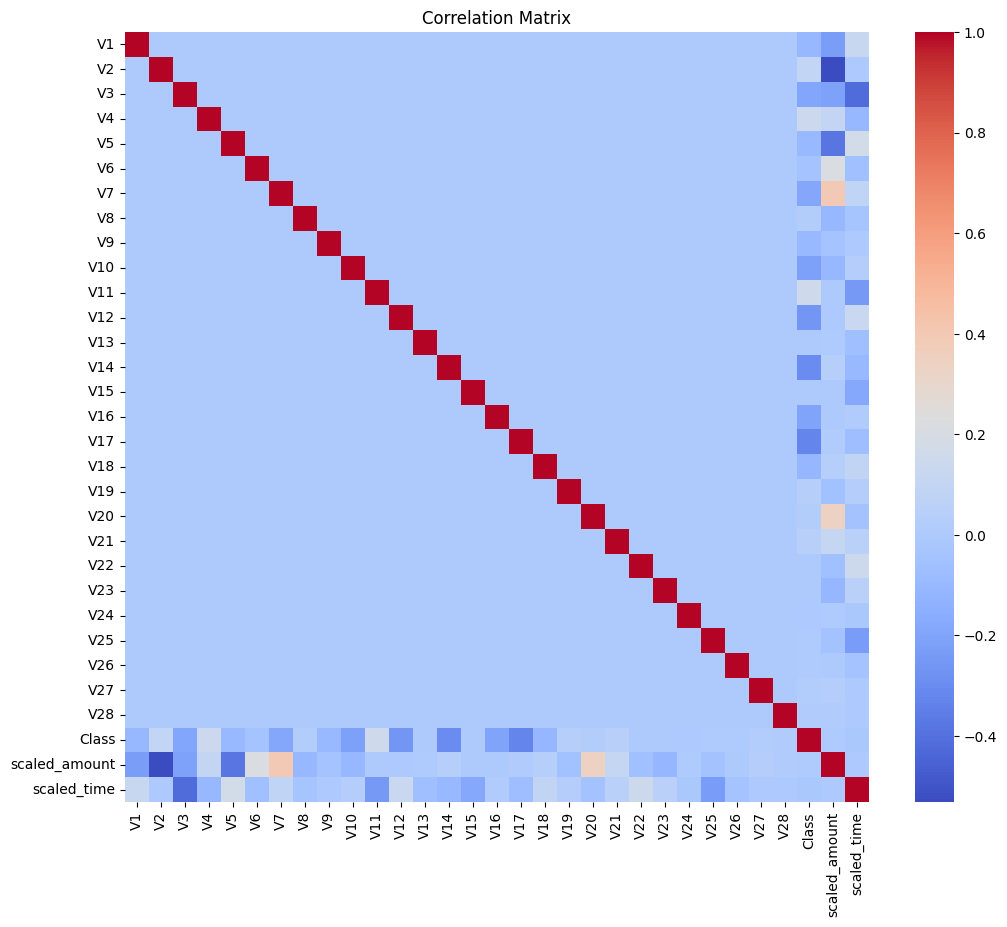

In [7]:
# 상관관계 히트맵 시각화
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [8]:
# 상관계수 값만 추출해서 정렬해보기
print(corr['Class'].sort_values(ascending=False))

Class            1.000000
V11              0.154876
V4               0.133447
V2               0.091289
V21              0.040413
V19              0.034783
V20              0.020090
V8               0.019875
V27              0.017580
V28              0.009536
scaled_amount    0.005632
V26              0.004455
V25              0.003308
V22              0.000805
V23             -0.002685
V15             -0.004223
V13             -0.004570
V24             -0.007221
scaled_time     -0.012323
V6              -0.043643
V5              -0.094974
V9              -0.097733
V1              -0.101347
V18             -0.111485
V7              -0.187257
V3              -0.192961
V16             -0.196539
V10             -0.216883
V12             -0.260593
V14             -0.302544
V17             -0.326481
Name: Class, dtype: float64


4. 데이터 분할 (Train/Test Split)

왜 **'층화 추출(Stratified Sampling)'** stratify=y를 써야 할까?

현재 사기 거래는 전체의 **0.17%**밖에 안 됩니다. 만약 무작위로 데이터를 나누면, 재수 없을 경우 테스트 데이터에 사기 거래가 단 한 건도 들어가지 않을 수 있습니다. 그러면 모델이 사기를 잘 잡는지 테스트하는 게 불가능해지겠죠?

stratify=y 옵션을 주면 학습 세트와 테스트 세트 모두 사기 거래 비율(0.17%)을 원본과 동일하게 유지해 줍니다.

In [9]:
from sklearn.model_selection import train_test_split

# 특징(X)과 타겟(y) 분리
X = df.drop('Class', axis=1)
y = df['Class']

# 데이터 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 비율 확인
print("학습 데이터 사기 비율:", y_train.value_counts(normalize=True)[1])
print("테스트 데이터 사기 비율:", y_test.value_counts(normalize=True)[1])

학습 데이터 사기 비율: 0.001729245759178389
테스트 데이터 사기 비율: 0.0017204452090867595


5. 오늘의 마지막 관문: 오버샘플링 (SMOTE)

데이터를 나눴지만, 여전히 학습 데이터 안에는 정상 거래가 압도적으로 많다. 모델은 "공부를 해보니 그냥 다 정상이라고 하는 게 속 편하네"라고 배울 위험이 큼. 때문에 적은 쪽(사기) 데이터를 인위적으로 늘려주는 SMOTE 기법을 사용.

**주의**: SMOTE는 반드시 학습 데이터(Train set)에만 적용해야 합니다. 테스트 데이터는 실제 세상의 데이터와 같아야 하므로 건드리면 안 됩니다. (이걸 '데이터 누수'라고 함. 단골 실수 포인트!)

In [10]:
from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습 데이터 크기:', X_train.shape)
print('SMOTE 적용 후 학습 데이터 크기:', X_train_over.shape)
print('SMOTE 적용 후 레이블 분포:\n', y_train_over.value_counts())

SMOTE 적용 전 학습 데이터 크기: (227845, 30)
SMOTE 적용 후 학습 데이터 크기: (454902, 30)
SMOTE 적용 후 레이블 분포:
 Class
0    227451
1    227451
Name: count, dtype: int64


이제 사기 거래와 정상 거래의 비율이 5:5가 되어 모델이 사기 패턴을 공부할 환경이 만들어짐!

1. SMOTE로 만든 인위적 데이터, 너무 많아도 괜찮을까?

결론부터 말씀드리면, **"학습 단계에서는 괜찮지만, 부작용(Noise)은 인지하고 있어야 한다"** 입니다.

왜 이렇게 많이 만들까?: 머신러닝 모델은 '오차(Loss)'를 줄이는 방향으로 공부합니다. 사기가 0.17%뿐이면 모델 입장에서 사기 500개를 다 틀려도 정확도가 99.8%나 되기 때문에, 굳이 사기를 잡으려고 애쓰지 않게 됩니다. SMOTE로 억지로 5:5 비율을 맞춰주는 것은 모델에게 **"사기 데이터를 공부하는 것이 점수 올리는 데 아주 중요하다!"** 라고 강제로 강조하는 주입식 교육과 같습니다.

부작용 (Overfitting to Noise): 지적하신 대로 인위적인 데이터가 너무 많아지면, 실제 사기의 특성이 아닌 **'가짜 데이터들 사이의 우연한 패턴'** 을 모델이 진실로 믿어버릴 위험이 있습니다. 이를 '과적합(Overfitting)'이라고 합니다.

해결책: 나중에 모델을 평가할 때, **'테스트 데이터(원본 비율 0.17% 그대로인 데이터)'** 에서 성능이 잘 나오는지 확인하는 것이 그래서 중요합니다. 만약 가짜 데이터에만 최적화되었다면 테스트 데이터에서는 점수가 엉망이 될 거예요. ("SMOTE의 부작용을 알고 있으며, 이를 위해 테스트 세트는 원본 분포를 유지해 엄격히 검증했다"라고 말하자!)